In [158]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [159]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


In [160]:
# Hardcoded control trajectory
# control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
#                                [0.000186, 0.008863, 0.002481],
#                                [0.000208, 0.00664, 0.003521],
#                                [0.000197, 0.004594, 0.004361],
#                                [0.000208, 0.002349, 0.005903],
#                                [0.000197, -0.00004, 0.006602],
#                                [0.000208, -0.00204, 0.007502],
#                                [0.000208, -0.00404, 0.008502]])
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000224, 0.010794, 0.003],
                               [0.000224, 0.010794, 0.005],
                               [0.000224, 0.010794, 0.007],
                               [0.000224, 0.010794, 0.009]])

In [161]:
target_point = np.array([0.00018, 0.009, 0])

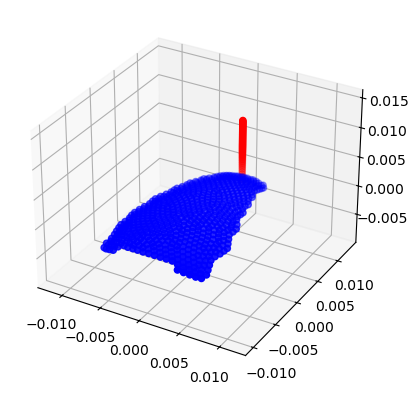

In [162]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()

In [163]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.init_grasp_constraints(loc=deepcopy(control_trajectory[0]), radius=1e-3)

cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

control point connects to 8 vertices


In [164]:
softbody.C_grasp_list

[tensor([ 31,  34,  35, 566, 577, 578, 579, 580], device='cuda:0')]

In [165]:
target_point = torch.from_numpy(target_point).to(cfg.device)

In [166]:
softbody.init_target_area(loc=deepcopy(target_point), radius=1e-3)

target point connects to 7 vertices


In [167]:
softbody.target_list

[tensor([ 26,  28,  29,  30, 554, 555, 567], device='cuda:0')]

In [168]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [169]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7fb7578ed300)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7fb764f40b20)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [170]:
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.grasp_point = control_trajectory[t].clone()

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

        mesh.points = softbody.V.cpu().numpy()
        # pl.show(interactive_update=True)

In [171]:
control_list = []
for i in softbody.C_grasp_list:
    control_list.append(i.cpu().numpy())

In [172]:
target_list = []
for i in softbody.target_list:
    target_list.append(i.cpu().numpy())

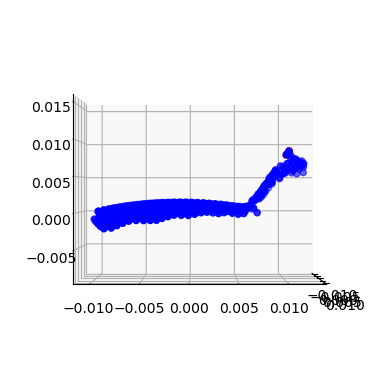

In [173]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [174]:
softbody.C_grasp_list

[tensor([ 31,  34,  35, 566, 577, 578, 579, 580], device='cuda:0')]

In [175]:
softbody.target_list

[tensor([ 26,  28,  29,  30, 554, 555, 567], device='cuda:0')]

In [176]:
softbody.V[softbody.target_list]

tensor([[ 1.1634e-05,  7.8046e-03,  3.1918e-03],
        [-1.1509e-05,  8.7978e-03,  5.0802e-03],
        [-2.8213e-04,  8.7382e-03,  4.2984e-03],
        [ 1.3004e-04,  8.2786e-03,  4.1770e-03],
        [ 6.8505e-04,  7.9584e-03,  3.7293e-03],
        [ 4.9565e-04,  8.4681e-03,  4.6219e-03],
        [ 2.0687e-04,  8.7993e-03,  5.2189e-03]], device='cuda:0')

In [177]:
target_pos = softbody.V[softbody.target_list].clone()

In [178]:
target_pos

tensor([[ 1.1634e-05,  7.8046e-03,  3.1918e-03],
        [-1.1509e-05,  8.7978e-03,  5.0802e-03],
        [-2.8213e-04,  8.7382e-03,  4.2984e-03],
        [ 1.3004e-04,  8.2786e-03,  4.1770e-03],
        [ 6.8505e-04,  7.9584e-03,  3.7293e-03],
        [ 4.9565e-04,  8.4681e-03,  4.6219e-03],
        [ 2.0687e-04,  8.7993e-03,  5.2189e-03]], device='cuda:0')

In [179]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


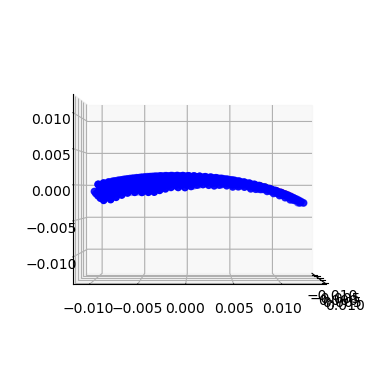

In [180]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)

In [181]:
# Hardcoded control trajectory
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000186, 0.008863, 0.002481],
                               [0.000208, 0.00664, 0.003521],
                               [0.000197, 0.004594, 0.004361],
                               [0.000208, 0.002349, 0.005903],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00204, 0.007502],
                               [0.000208, -0.00404, 0.008502]])
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [182]:
trajectory = torch.from_numpy(control_trajectory[0]).to(cfg.device)

In [183]:
# softbody.init_target_area(loc=deepcopy(target_point), radius=1e-3)
# softbody.init_control_area(loc=deepcopy(trajectory), radius=1e-3)
# softbody.init_grasp_constraints(loc=deepcopy(trajectory), radius=1e-3)

target point connects to 7 vertices
target point connects to 8 vertices


In [184]:
softbody.V[softbody.target_list]

tensor([[-1.8041e-04,  8.0801e-03, -6.0673e-05],
        [-2.9936e-04,  9.2322e-03, -5.0077e-04],
        [-5.3550e-04,  8.6093e-03, -2.6205e-04],
        [ 8.5739e-05,  8.6973e-03, -2.9211e-04],
        [ 4.7816e-04,  8.1508e-03, -1.1330e-04],
        [ 6.9870e-04,  8.7647e-03, -3.5961e-04],
        [ 3.0284e-04,  9.3302e-03, -5.5665e-04]], device='cuda:0')

In [185]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [186]:
softbody.V.requires_grad_(True)
softbody.V_velocity.requires_grad_(True)
# softbody.grasp_point.requires_grad_(True)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0', requires_grad=True)

In [187]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
optimizer = torch.optim.Adam([softbody.V[control_point]], lr=0.01)

In [188]:
control = []
for t in range(100):
    print(t)
    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)

    ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    # print(torch.sigmoid(1e9 * (1e-8 - energy)))
    # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
    V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy))

    loss = loss_fn(target_pos, V_ref[softbody.target_list])
    loss.backward()

    if loss > 1e-4:
        with torch.no_grad():
            V_ref[softbody.control_list] -= 0.1* softbody.V.grad[softbody.control_list]
    control.append(V_ref[softbody.control_list].detach().cpu().numpy())
    print('loss:', loss)
    # print(softbody.V.grad[softbody.control_list])
    print(V_ref[softbody.control_list])
    softbody.V = V_ref.detach().clone().requires_grad_(True)
    softbody.V_velocity = V_velocity_ref.detach().clone().requires_grad_(True)

    
    # mesh.points = softbody.V.cpu().numpy()

0
loss: tensor(0.0126, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([[-0.0004,  0.0102, -0.0010],
        [-0.0001,  0.0116, -0.0017],
        [-0.0002,  0.0109, -0.0013],
        [ 0.0006,  0.0098, -0.0008],
        [ 0.0010,  0.0103, -0.0011],
        [ 0.0003,  0.0104, -0.0011],
        [ 0.0009,  0.0109, -0.0014],
        [ 0.0003,  0.0112, -0.0015]], device='cuda:0',
       grad_fn=<IndexBackward0>)
1
loss: tensor(0.0126, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([[-0.0004,  0.0102, -0.0010],
        [-0.0001,  0.0116, -0.0017],
        [-0.0002,  0.0109, -0.0013],
        [ 0.0006,  0.0098, -0.0009],
        [ 0.0010,  0.0103, -0.0011],
        [ 0.0003,  0.0104, -0.0011],
        [ 0.0009,  0.0109, -0.0014],
        [ 0.0003,  0.0111, -0.0015]], device='cuda:0',
       grad_fn=<IndexBackward0>)
2
loss: tensor(0.0126, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([[-0.0004,  0.0102, -0.0010],
        [-0.0001,  0.0116, -0.0017],
 

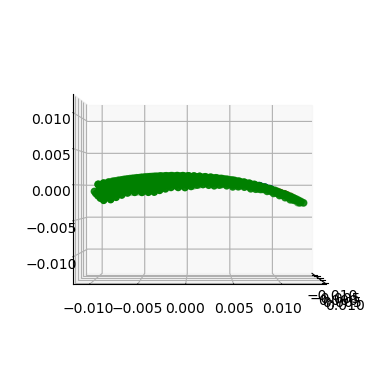

In [194]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o')
ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='b', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [190]:
V_ref[softbody.target_list]

tensor([[-1.8053e-04,  8.0793e-03, -8.0513e-05],
        [-2.9951e-04,  9.2313e-03, -5.1952e-04],
        [-5.3560e-04,  8.6085e-03, -2.8083e-04],
        [ 8.5670e-05,  8.6965e-03, -3.1134e-04],
        [ 4.7813e-04,  8.1497e-03, -1.3293e-04],
        [ 6.9880e-04,  8.7637e-03, -3.7861e-04],
        [ 3.0283e-04,  9.3292e-03, -5.7548e-04]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [191]:
softbody.V[softbody.control_list]

tensor([[-0.0004,  0.0102, -0.0010],
        [-0.0001,  0.0116, -0.0017],
        [-0.0002,  0.0109, -0.0013],
        [ 0.0007,  0.0098, -0.0010],
        [ 0.0010,  0.0103, -0.0011],
        [ 0.0003,  0.0104, -0.0011],
        [ 0.0009,  0.0109, -0.0014],
        [ 0.0003,  0.0111, -0.0015]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [192]:
softbody.V[softbody.target_list]

tensor([[-1.8053e-04,  8.0793e-03, -8.0513e-05],
        [-2.9951e-04,  9.2313e-03, -5.1952e-04],
        [-5.3560e-04,  8.6085e-03, -2.8083e-04],
        [ 8.5670e-05,  8.6965e-03, -3.1134e-04],
        [ 4.7813e-04,  8.1497e-03, -1.3293e-04],
        [ 6.9880e-04,  8.7637e-03, -3.7861e-04],
        [ 3.0283e-04,  9.3292e-03, -5.7548e-04]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [193]:
control

[array([[-0.00036623,  0.01022517, -0.00097879],
        [-0.00014886,  0.01155853, -0.00167036],
        [-0.00020324,  0.01087727, -0.00129051],
        [ 0.00062175,  0.00983687, -0.00084925],
        [ 0.00097278,  0.01033251, -0.00111592],
        [ 0.00034235,  0.01039643, -0.00108809],
        [ 0.00085959,  0.01088143, -0.00137038],
        [ 0.00032899,  0.01116005, -0.00146346]], dtype=float32),
 array([[-0.00036747,  0.01020162, -0.00103042],
        [-0.00014766,  0.0115588 , -0.00167124],
        [-0.00020417,  0.01088771, -0.00129252],
        [ 0.00060588,  0.00981635, -0.00089896],
        [ 0.00097463,  0.01033829, -0.00111622],
        [ 0.00032935,  0.01039271, -0.00113526],
        [ 0.00086116,  0.01087146, -0.00136903],
        [ 0.00033169,  0.01114895, -0.00146049]], dtype=float32),
 array([[-0.0003658 ,  0.0101841 , -0.00100637],
        [-0.00014842,  0.01155898, -0.00167102],
        [-0.00020584,  0.01089088, -0.00129467],
        [ 0.00058968,  0.00980188, 